<h1 style="font-size: 34px; margin-bottom: 0px;">Prognoza cen akcji na kilka dni do przodu</h1>

Kto nie chciałby znać jutrzejszej ceny akcji. Na rynek akcji wpływ ma wiele czynników i prognozowanie cen w krótkim terminie jest niezwykle trudnym zadaniem.
Korzystając z danych historycznych będę starał się prognozować ceny na najbliższe dni wykorzystując modele regresji z wykorzystaniem współczynników analizy technicznej.

![](graphic/01_head.jpeg)

# Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

#technical analysis
import ta

# pipeline
from sklearn.pipeline import Pipeline

# data processing
from sklearn.preprocessing import MinMaxScaler

# optimization and hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#metrics
from sklearn.metrics import mean_squared_error

#web interface
import gradio as gr

#my function
from my_functions import load_data, plot_candle, calculate_mape, calculate_MAPE_diff_price
from my_functions import edit_predictions, generate_target, generate_features
import warnings
warnings.filterwarnings("ignore")

# Load Data

Za pomocą przygotowanej funkcji wczytuję dane historyczne ze strony https://stooq.com/ oraz dodaję kolumnę 'Company' aby móc identyfikować dane konkretnej spółki.

In [2]:
company_names = ['ibm', 'tsla', 'bp', 'wmt', 'ba', 'msft', 'nke', 'pkn', 'cdr', 'pko']
my_df = pd.DataFrame()

for i, company_name in enumerate(company_names):
    df = load_data(company_name)
    df['Company'] = company_name.upper()    
    my_df = pd.concat([my_df, df], axis=0)

my_df.sort_values(by=['Date', 'Company'], inplace=True)
column_sorted = ['Date', 'Company'] + [col for col in my_df.columns if col not in ['Date', 'Company']]
my_df = my_df[column_sorted]
my_df.reset_index(drop=True, inplace=True)
    
my_df

,Date,Company,Open,High,Low,Close,Volume
0,1962-01-02,IBM,5.04610,5.04610,4.98716,4.98716,5.935630e+05
1,1962-01-03,IBM,4.98716,5.03292,4.98716,5.03292,4.451750e+05
2,1962-01-04,IBM,5.03292,5.03292,4.98052,4.98052,3.995136e+05
3,1962-01-05,IBM,4.97389,4.97389,4.87511,4.88166,5.593215e+05
4,1962-01-08,IBM,4.88166,4.88166,4.75059,4.78972,8.332738e+05
...,...,...,...,...,...,...,...
86267,2023-08-23,NKE,96.98000,98.50000,96.54500,97.88000,8.489606e+06
86268,2023-08-23,PKN,64.16000,64.66000,63.53000,64.16000,1.366324e+06
86269,2023-08-23,PKO,36.75000,37.29000,36.53000,37.02000,1.978827e+06
86270,2023-08-23,TSLA,229.34000,235.64000,229.29000,234.93000,3.777110e+07


Tworzę dwie nowe zmienne:
- 'Close_pred' - aby łatwo sprawdzać prognozy
- 'Close_diff' - abym mógł utworzyć target jako zmiana ceny na kolejne 5 dni

In [3]:
my_df['Close_pred'] = my_df.groupby('Company')['Close'].apply(lambda x: x.shift(-1))
my_df['Close_diff'] = my_df.groupby('Company')['Close'].apply(lambda x: (x - x.shift(1)))

In [4]:
my_df

,Date,Company,Open,High,Low,Close,Volume,Close_pred,Close_diff
0,1962-01-02,IBM,5.04610,5.04610,4.98716,4.98716,5.935630e+05,5.03292,NaN
1,1962-01-03,IBM,4.98716,5.03292,4.98716,5.03292,4.451750e+05,4.98052,0.04576
2,1962-01-04,IBM,5.03292,5.03292,4.98052,4.98052,3.995136e+05,4.88166,-0.05240
3,1962-01-05,IBM,4.97389,4.97389,4.87511,4.88166,5.593215e+05,4.78972,-0.09886
4,1962-01-08,IBM,4.88166,4.88166,4.75059,4.78972,8.332738e+05,4.84867,-0.09194
...,...,...,...,...,...,...,...,...,...
86267,2023-08-23,NKE,96.98000,98.50000,96.54500,97.77000,8.428765e+06,NaN,-3.69000
86268,2023-08-23,PKN,64.16000,64.66000,63.53000,64.16000,1.366324e+06,NaN,-0.15000
86269,2023-08-23,PKO,36.75000,37.29000,36.53000,37.02000,1.978827e+06,NaN,0.31000
86270,2023-08-23,TSLA,229.34000,235.59000,229.29000,235.55200,3.709134e+07,NaN,2.36200


# Exploratory Data Analysis

                                            Wybrane spółki:

| Nazwa:                | Ticker:    | Branża:                      |
|-----------------------|------------|------------------------------|
| INT BUSINESS MACHINES | IBM        | Technologie informacyjne     |
| Tesla                 | TSLA       | Produkcja Samochodów         |
| BP                    | BP         | Energetyczna                 |
| Walmart Inc           | WMT        | Sprzedaż detaliczna i hurtowa|
| Boeing Co             | BA         | Lotnictwo                    |
| Microsoft Corp        | MSFT       | Technologie informacyjne     |
| NIKE Inc              | NKE        | Obuwie i akcesoria           |
| PKN ORLEN SA          | PKN        | Energetyczna                 |
| CD Projekt SA         | CDR        | Elektroniczna rozrywka       |
| PKO Bank Polski SA    | PKO        | Finanse                      |

In [6]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86272 entries, 0 to 86271
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        86272 non-null  datetime64[ns]
 1   Company     86272 non-null  object        
 2   Open        86272 non-null  float64       
 3   High        86272 non-null  float64       
 4   Low         86272 non-null  float64       
 5   Close       86272 non-null  float64       
 6   Volume      86272 non-null  float64       
 7   Close_pred  86262 non-null  float64       
 8   Close_diff  86262 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 5.9+ MB


Gdzie są wartości brakujące?

In [7]:
my_df.loc[my_df.isnull().any(axis=1)]

,Date,Company,Open,High,Low,Close,Volume,Close_pred,Close_diff
0,1962-01-02,IBM,5.046100,5.046100,4.987160,4.987160,5.935630e+05,5.032920,NaN
1987,1970-01-02,BA,0.723100,0.771100,0.723100,0.771100,7.902790e+05,0.795200,NaN
3109,1972-03-20,WMT,0.030898,0.030898,0.030898,0.030898,3.450104e+06,0.030898,NaN
13628,1986-03-13,MSFT,0.062951,0.070576,0.062951,0.070576,1.463519e+09,0.070576,NaN
15081,1987-08-19,NKE,0.233013,0.235184,0.226478,0.230891,1.396600e+07,0.233013,NaN
23869,1994-08-02,CDR,7.903370,7.903370,7.903370,7.903370,3.636020e+05,8.680640,NaN
31905,1999-11-26,PKN,13.416100,13.534700,12.930200,13.351100,1.804577e+07,13.113000,NaN
40606,2004-11-10,PKO,13.657900,14.481800,13.657900,14.424000,9.934619e+07,14.541300,NaN
41194,2005-02-25,BP,33.491200,33.756200,33.366300,33.630500,1.387447e+07,33.556000,NaN
53238,2010-06-29,TSLA,1.266670,1.666670,1.169330,1.592670,2.817491e+08,1.588670,NaN


Jedyne brakujące wartości to nowo utworzona kolumna 'Close_diff' i nie jest wyznaczona tylko dla pierwszego rekordu każdej spółki, więc można usunąć te braki. Dane z ostatniego dnia również mogę usunąć bo modele będę testował na danych do 2023-07-31.

In [8]:
my_df = my_df.dropna(axis=0)
my_df.reset_index(drop=True, inplace=True)

In [9]:
my_df.loc[my_df.isnull().any(axis=1)]

,Date,Company,Open,High,Low,Close,Volume,Close_pred,Close_diff


Jaki jest udział poszczególnych spółek w zbiorze?

In [10]:
my_df['Company'].value_counts()

IBM     15510
BA      13525
WMT     12894
MSFT     9434
NKE      9071
CDR      7217
PKN      5941
PKO      4700
BP       4652
TSLA     3308
Name: Company, dtype: int64

Wykresy świecowe wraz z wolumenem

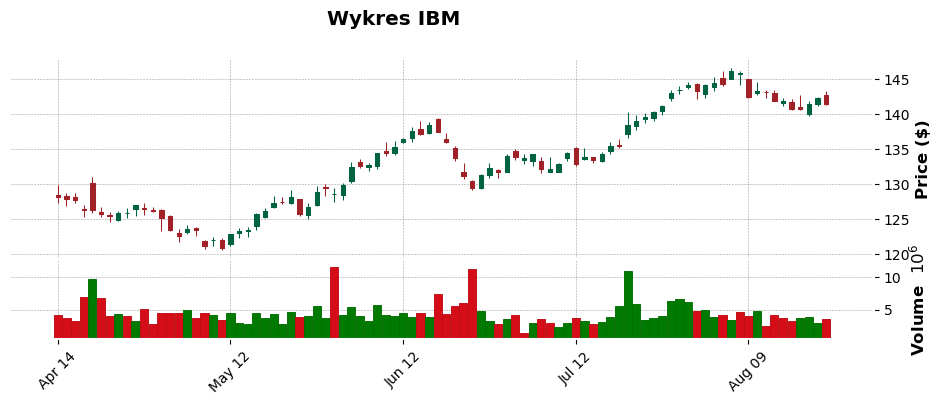

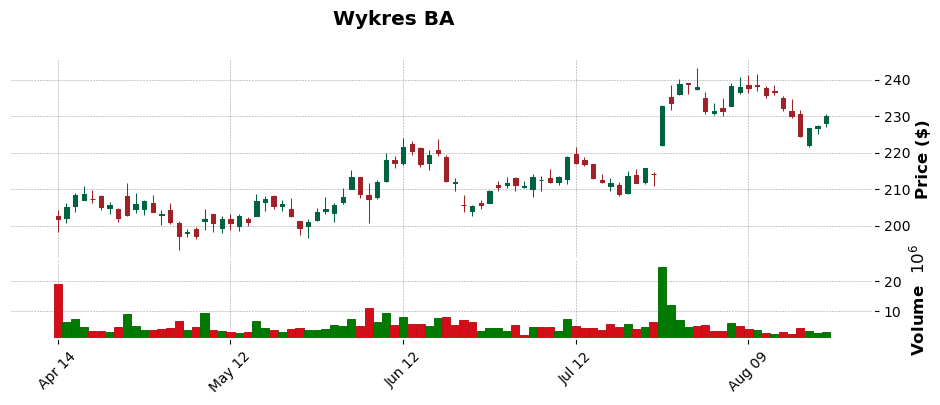

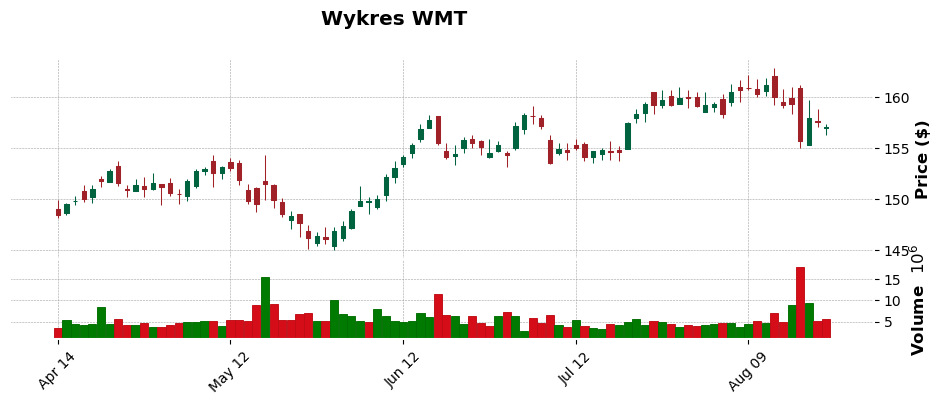

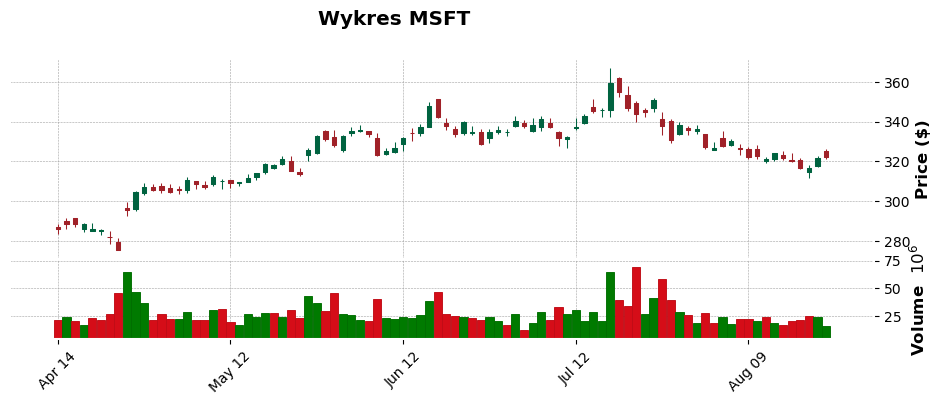

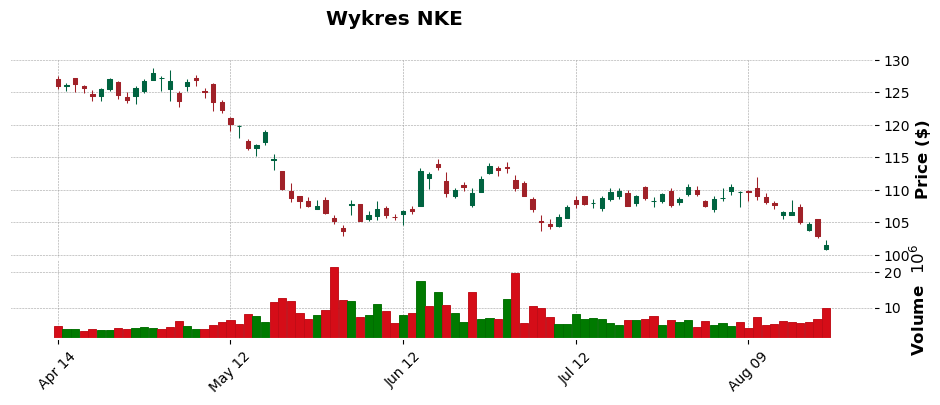

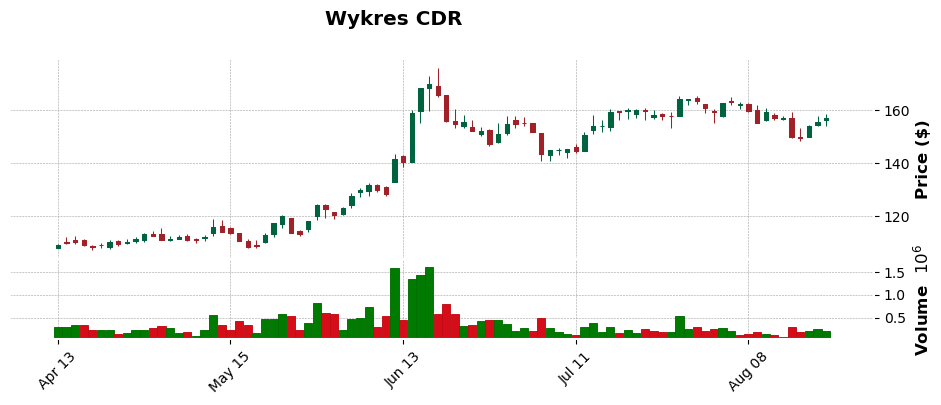

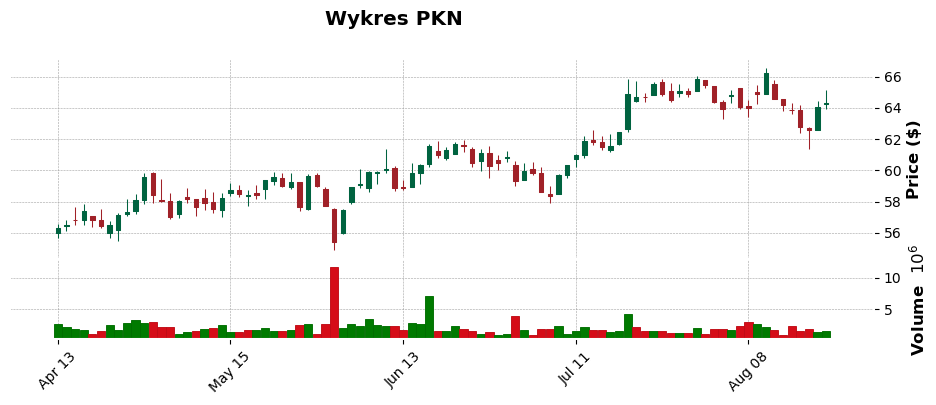

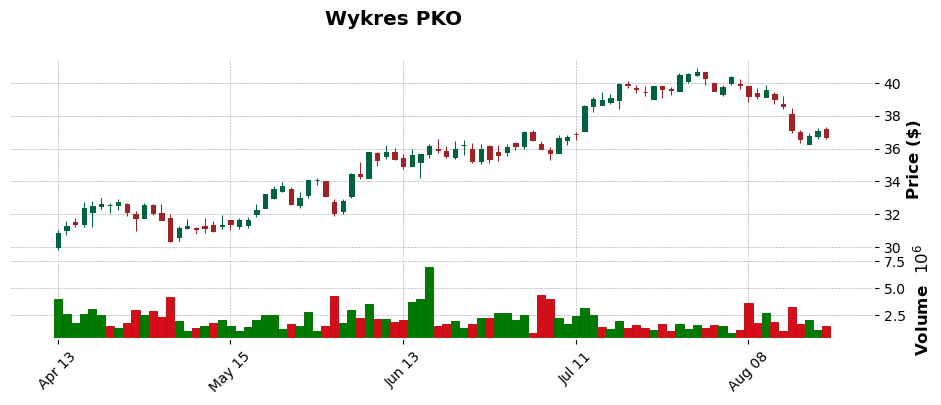

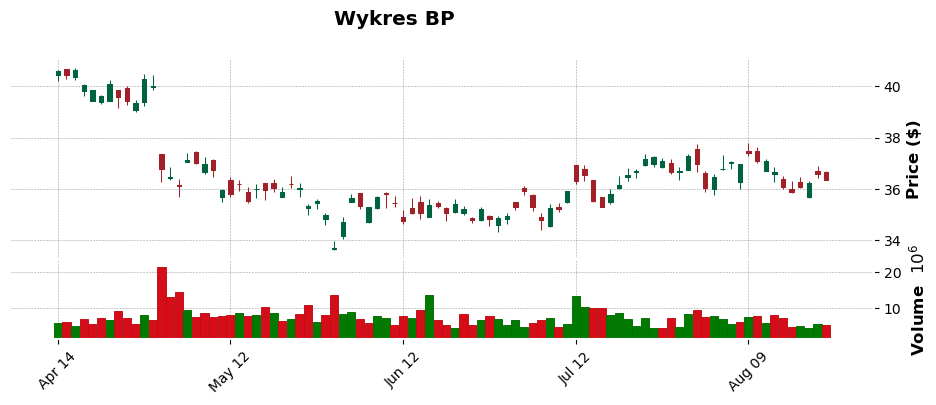

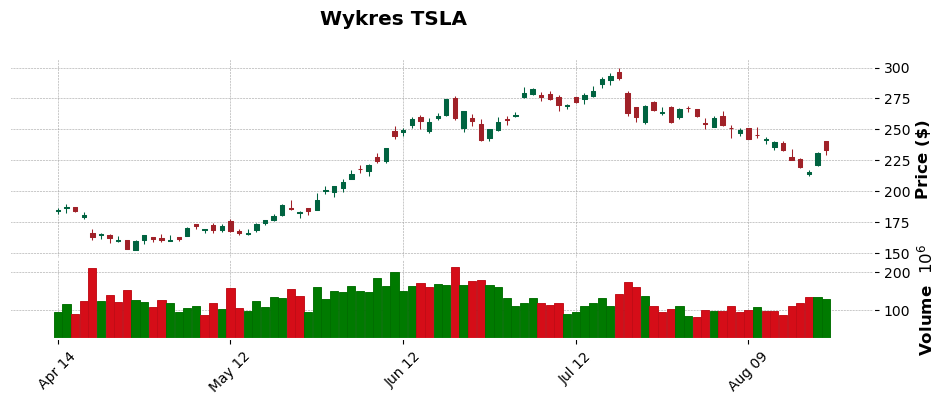

In [14]:
for name in my_df['Company'].unique():
    plot_candle(my_df, name, 90, figsize = (12, 4))

# Data Preprocessing - Feature Engineering

Utworzone cechy: 
- Close_diff - zmiana ceny zamknięcia,
- Close_diff_perc - procentowa zmiana ceny zamknięcia,
- Open_diff - zmiana ceny otwarcia,
- Close_Open_diff - różnica między ceną otwarcia i zamknięcia,
- Ratio_volume_1d_yd - stosunek dzisiejszego i wczorajszego wolumenu
- Ratio_volume_1d_1w - stosunek wolumenu ze średnią wolumenów z ostatniego tygodnia,
- Ratio_close_diff_1d_1w - stosunek Close_diff i jego odchylenia standardowego z ostatniego tygodnia,
- Ratio_close_diff_1d_2w - stosunek Close_diff i jego odchylenia standardowego z ostatnich w tygodni,
- Ratio_close_diff_1w_2w - stosunek odchylenia stand. Close_diff z ostatniego tygodnia i 2 tygodni,
- Return_1d - zwrot z ostatniego dnia,
- Return_1w - zwrot z ostatniego tygodnia,
- Ratio_close_SMA_5 - stosunek ceny zamknięcia do średniej kroczącej cen zamknięcia z ostatniego tygodnia,
- Ratio_close_SMA_10 - stosunek ceny zamknięcia do średniej kroczącej cen zamknięcia z ostatnich 2 tygodni,
- Close_SMA_5_diff - róznica pomiędzy ceną zamknięcia a średnią kroczącą ceny zamknięcia z ostatniego tygodnia,
- MACD - linia MACD, która jest różnicą między dwiema wykładniczymi średnimi kroczącymi (12 i 26 dni),
- MACD_diff - różnica między MACD a jego sygnałem,
- MACD_signal - linia sygnału MACD,
- CCI - mierzy odchylenie bieżącej ceny od jej średniej kroczącej (typowo za ostatnie 20 lub 14 okresów)
- TSI - głównym celem TSI jest wykrywanie ukrytych odwróceń trendu i potwierdzanie bieżącego trendu
- ROC_10 - wskaźnik szybkości zmiany na podstawie ostatnich 10 dni cen zamknięcia,
- MI - wskaźnik masy, który mierzy zmienność cen,
- OBV - wolumen zrównoważony, który pomaga ocenić przepływ kapitału do lub z akcji,
- RSI - wskaźnik
- ADX - średni wskaźnik kierunkowy, który pomaga ocenić siłę trendu na rynku,

Podzielę zbiór na treningowy i testowy z wykorzystaniem przygotowanej funkcji, która wygeneruje również moje nowe cechy. Zbiór testowy będzie zawierał dane od 2023-01-01 do 2023-07-31.

In [4]:
X_train, y_train, X_test, y_test, y_train_price, y_test_price = generate_target(my_df, days_to_forecast = 5, first_test_day = '2023-01-01', last_test_day = '2023-07-31')

Generating Date Features: 100%|████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


In [21]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (82121, 32)
y_train shape: (82121, 5)
X_test shape: (1443, 32)
y_test shape: (1443, 5)


# Baseline Model
Do modelu podstawowego będę porównywał moje modele. Założeniem mojego modelu będzie to, że cena jutrzejsza nie zmieni się w stosunku do ceny dzisiejszej. Do porównania wyznaczę MAPE na zbiorze testowym.

In [13]:
X_test[['Date', 'Company', 'Close_pred', 'Close']]

,Date,Company,Close_pred,Close
82121,2023-01-02,CDR,128.0030,128.3400
82122,2023-01-02,PKN,60.0410,59.4885
82123,2023-01-02,PKO,31.7600,30.2700
82124,2023-01-03,BA,203.6400,195.3900
82125,2023-01-03,BP,33.7800,34.3200
...,...,...,...,...
83559,2023-07-31,NKE,109.4000,110.3900
83560,2023-07-31,PKN,65.4742,65.8333
83561,2023-07-31,PKO,40.3300,40.6600
83562,2023-07-31,TSLA,261.0700,267.4300


Mój zbiór testowy zawiera dane od 2023-01-01 do 2023-07-31

In [14]:
calculate_mape(X_test['Close_pred'], X_test['Close'])

1.391776293528869

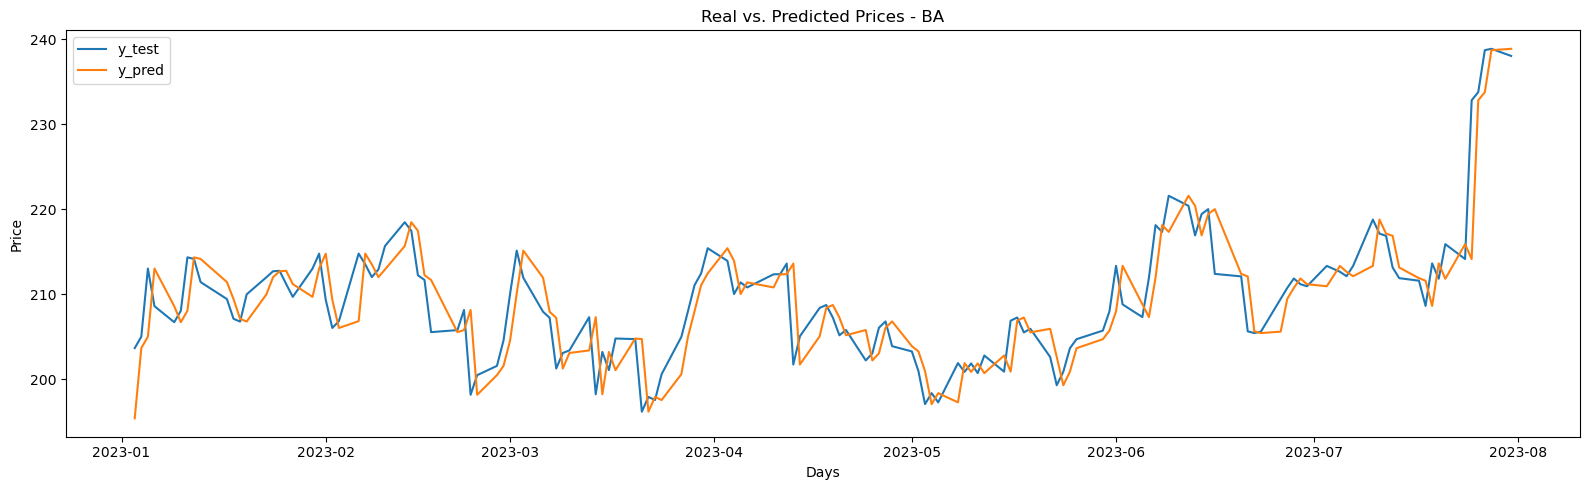

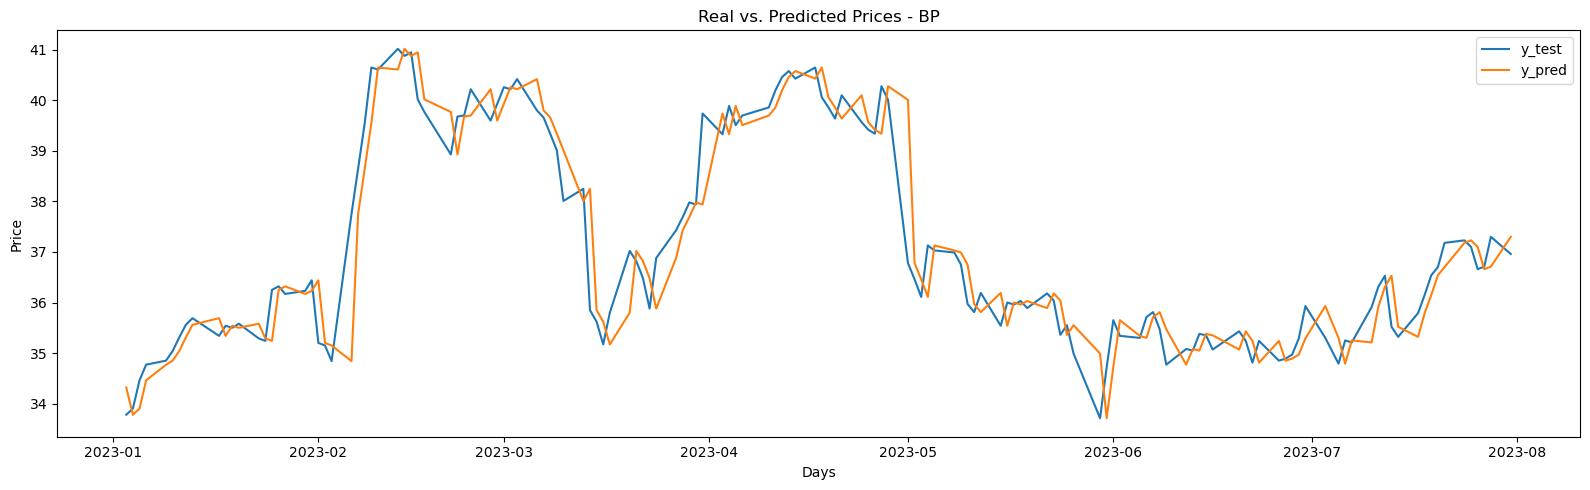

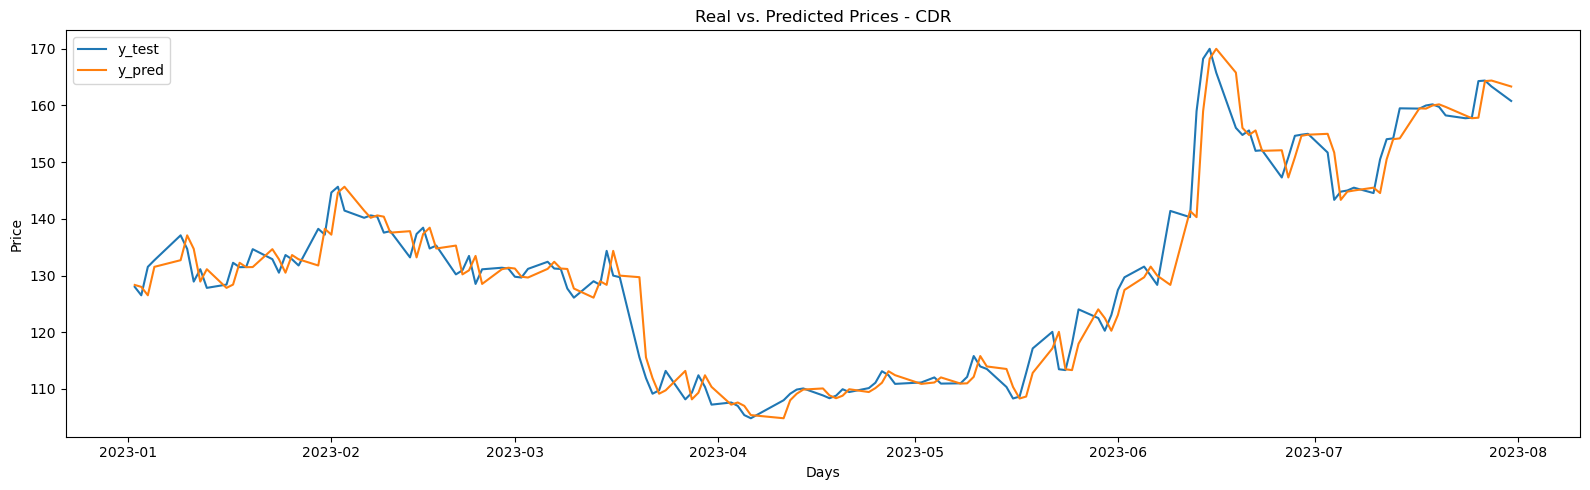

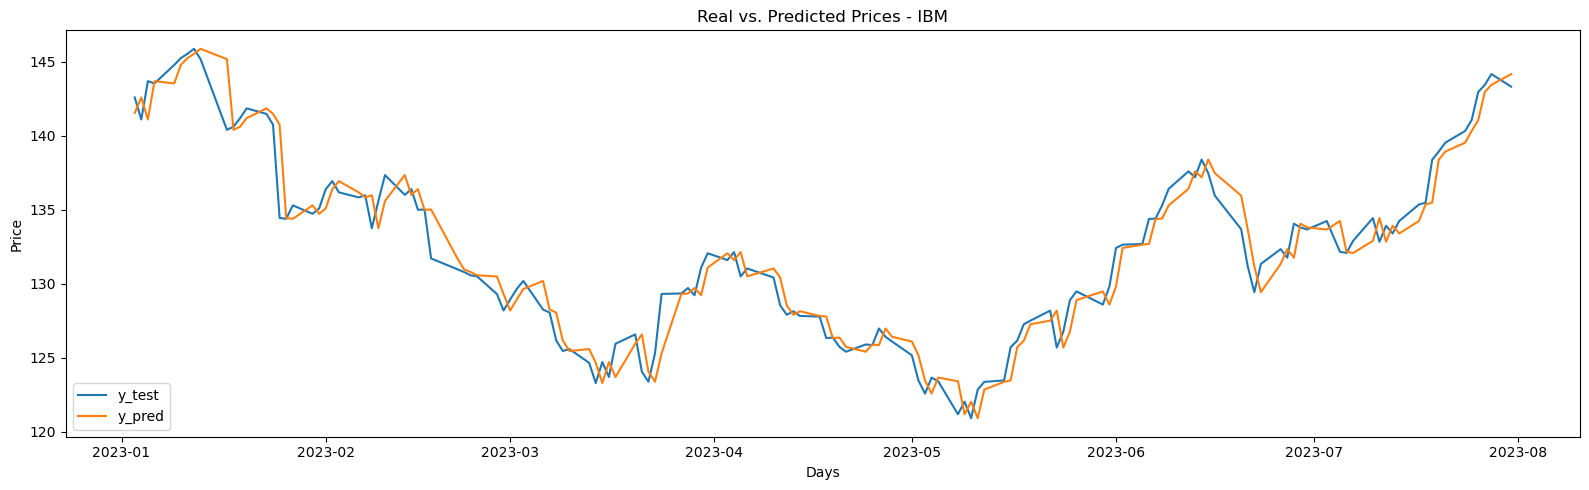

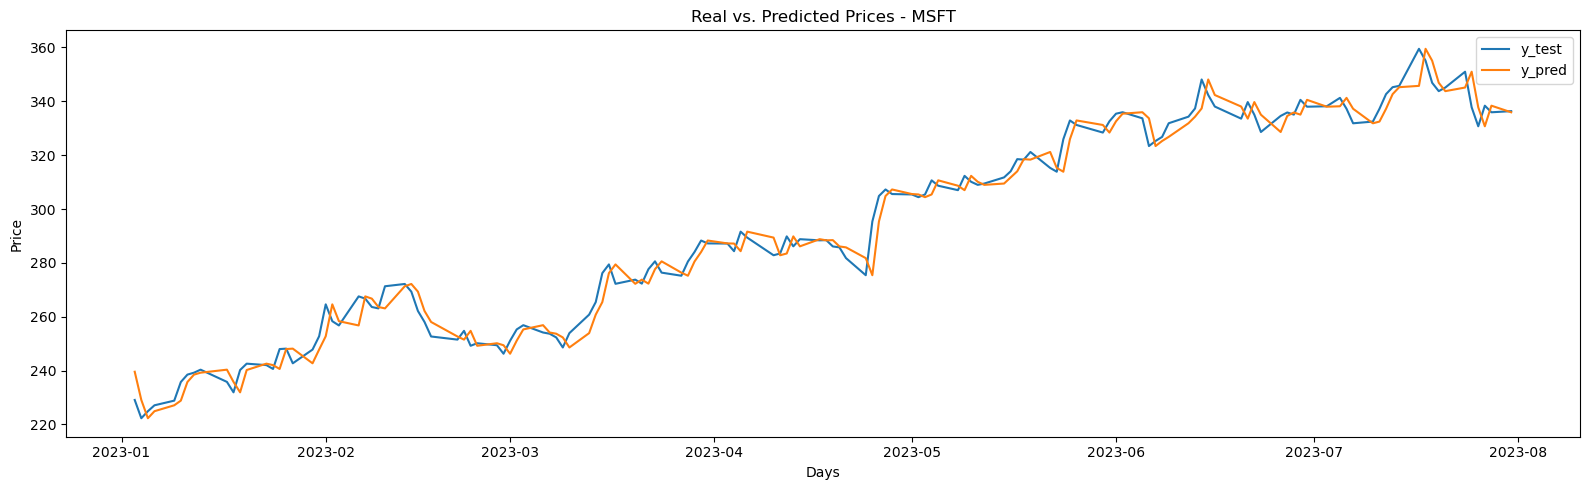

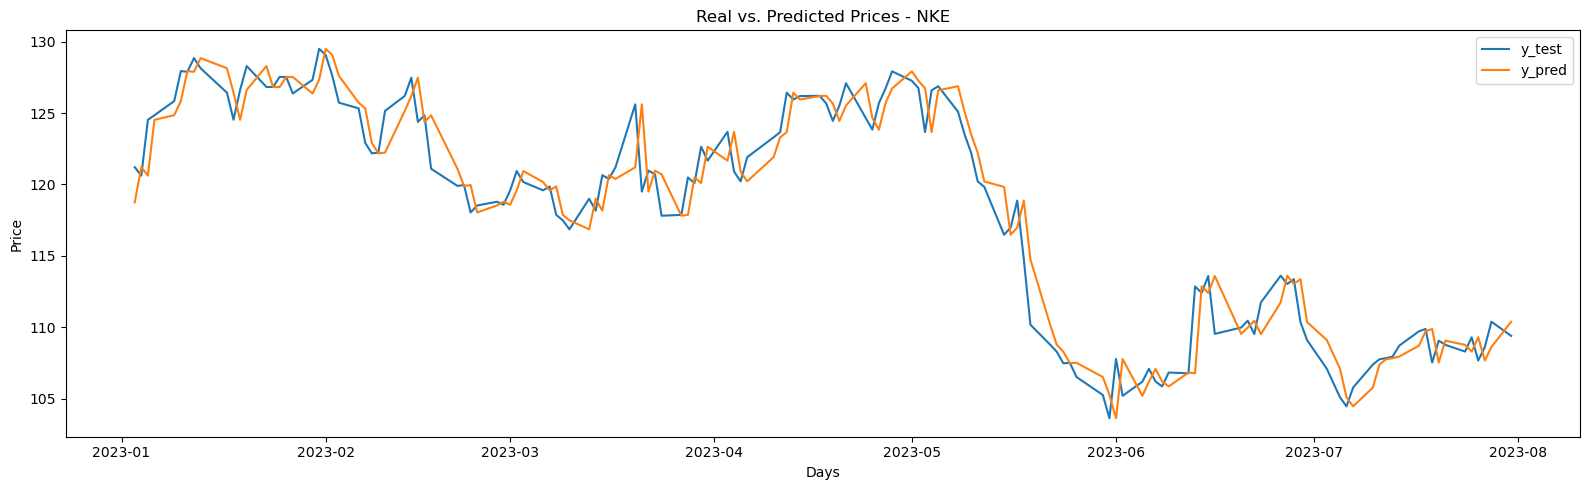

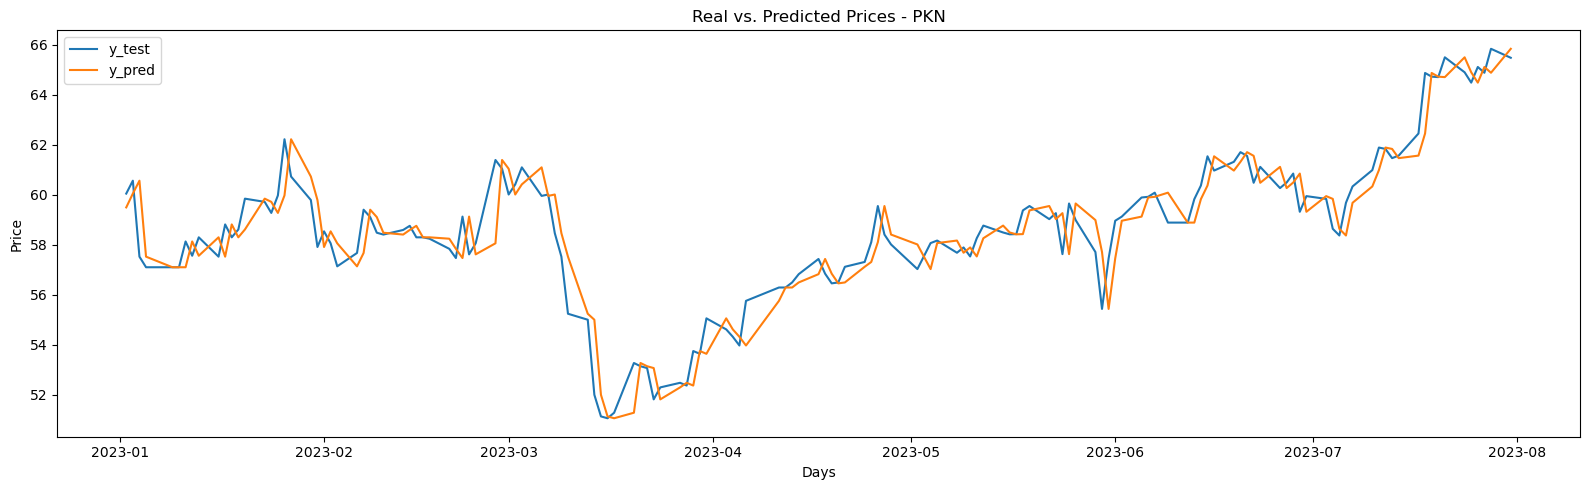

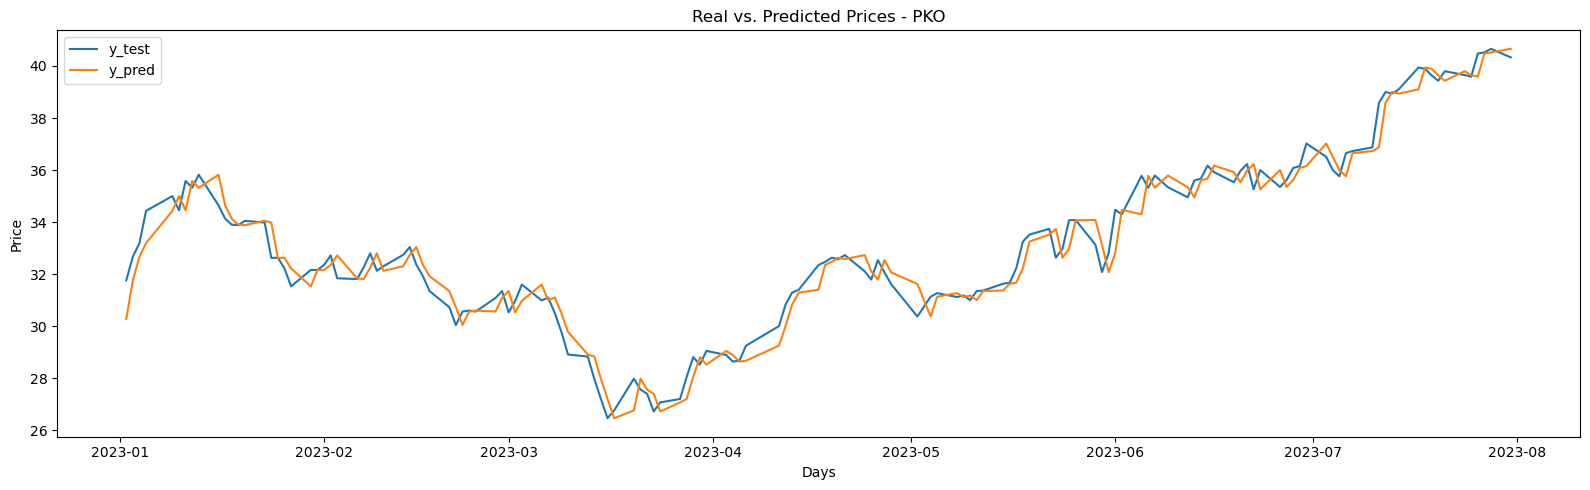

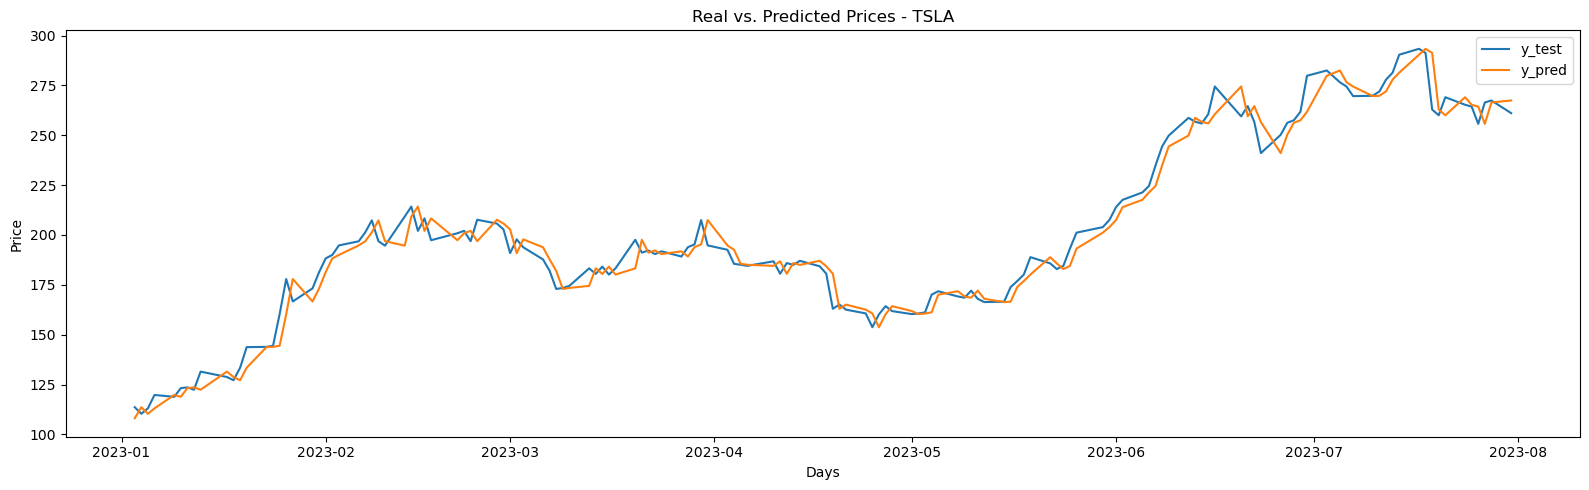

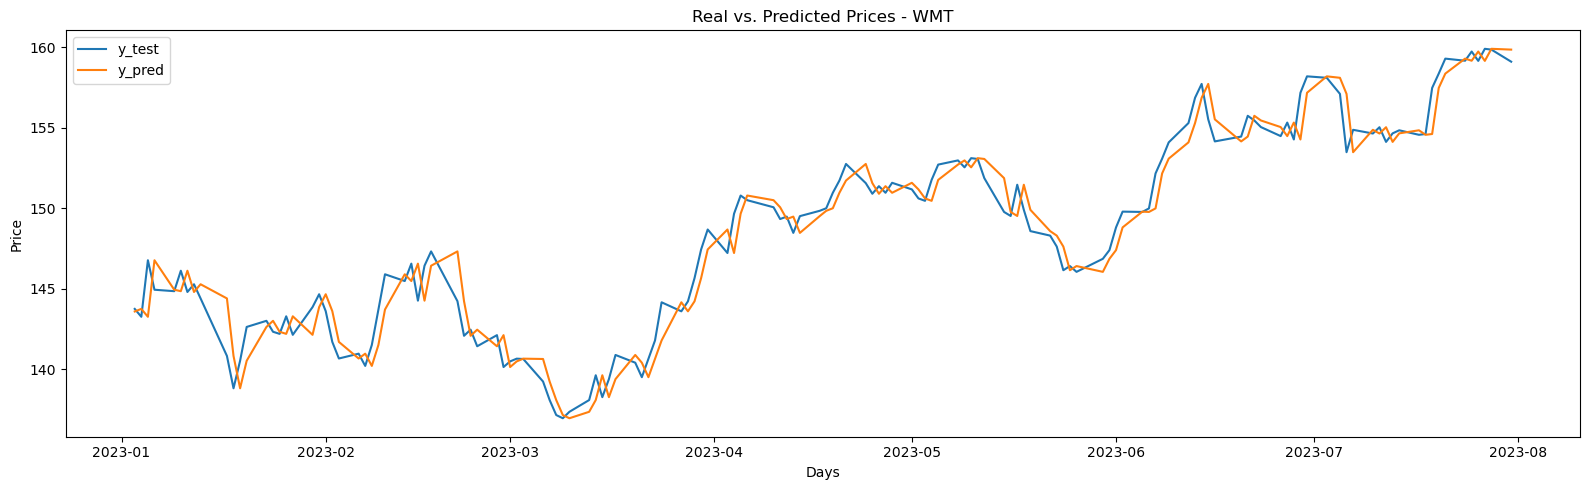

In [15]:
grouped = X_test.groupby('Company')

for name, group in grouped:
    plt.figure(figsize=(16, 5))
    plt.plot(group['Date'], group['Close_pred'], label='y_test')
    plt.plot(group['Date'], group['Close'], label='y_pred')
    plt.legend()

    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'Real vs. Predicted Prices - {name}')
    plt.tight_layout()
    plt.show()

# Feature extraction

## Feature importance

In [26]:
test_feature = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_split=10, random_state=42)
test_feature.fit(X_train.iloc[:,8:], y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

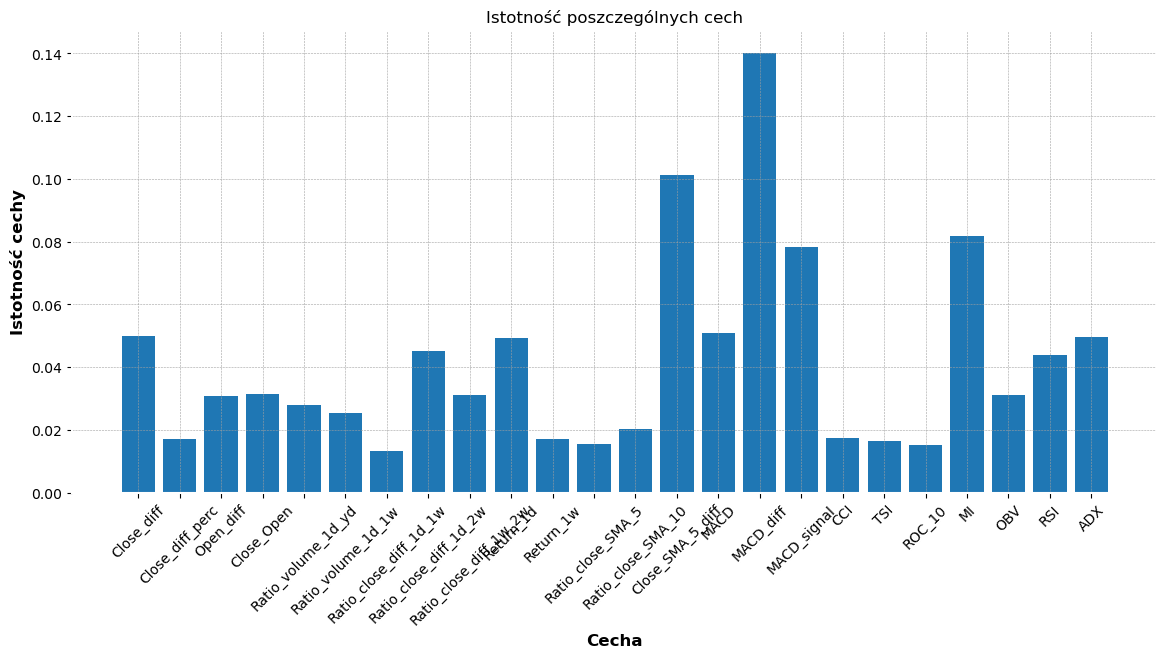

In [35]:
feature_importance = test_feature.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(X_train.iloc[:,8:].columns, feature_importance)
plt.xlabel('Cecha')
plt.ylabel('Istotność cechy')
plt.title('Istotność poszczególnych cech')
plt.xticks(rotation=45)
plt.show()

## Feature correlation

Sprawdzenie korelacji pomiędzy cechami a 'Close_diff'

In [38]:
corr_matrix = X_train.corr()
correlations_y = corr_matrix['Close_diff']
sorted_correlations_y = correlations_y.abs().sort_values(ascending=False)
print(sorted_correlations_y)

Close_diff                1.000000
Close_Open                0.818825
Close_SMA_5_diff          0.731259
Close_diff_perc           0.469940
Ratio_close_diff_1d_2w    0.446016
Ratio_close_diff_1d_1w    0.413275
Ratio_close_SMA_5         0.359875
Open_diff                 0.278892
Ratio_close_SMA_10        0.268753
MACD_diff                 0.195834
RSI                       0.170514
CCI                       0.169107
ROC_10                    0.165397
MACD                      0.067276
TSI                       0.035604
Close                     0.020572
Close_pred                0.019902
Low                       0.011357
Ratio_volume_1d_1w        0.010444
High                      0.008822
MACD_signal               0.008015
Return_1d                 0.007584
Return_1w                 0.007235
Volume                    0.006382
OBV                       0.003786
ADX                       0.003468
Ratio_close_diff_1w_2w    0.002125
MI                        0.001837
Ratio_volume_1d_yd  

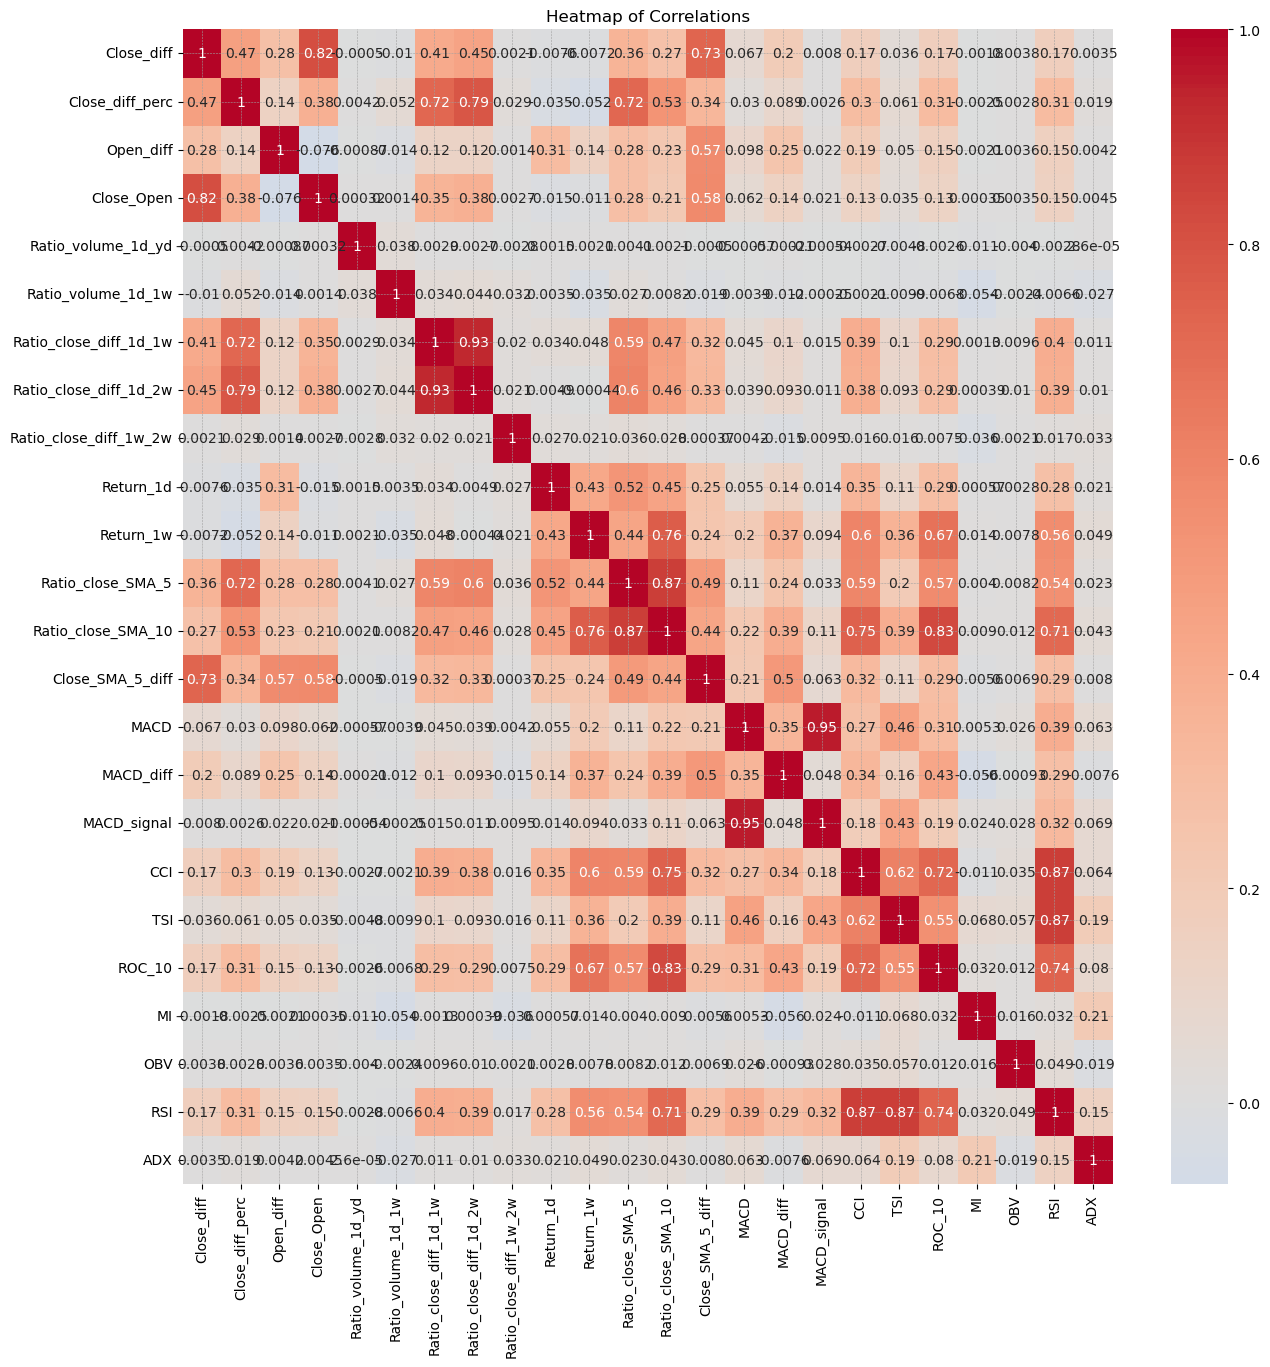

In [40]:
corr_matrix = X_train.iloc[:,8:].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlations')
plt.show()

# Models

## LinearRegression

In [5]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('linear_regression', LinearRegression())
])

pipeline_lr.fit(X_train.iloc[:,8:], y_train)

y_pred_lr = pipeline_lr.predict(X_test.iloc[:,8:])

In [6]:
calculate_MAPE_diff_price(X_test, y_test_price, pipeline_lr)

MAPE 1 dzień: 3.17%
MAPE 5 dni: 7.31%


## Model Random forest

In [45]:
model_RF = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_split=10, random_state=42)
model_RF.fit(X_train.iloc[:,8:], y_train)
y_pred_rf = model_RF.predict(X_test.iloc[:,8:])

In [62]:
calculate_MAPE_diff_price(model_RF)

MAPE 1 dzień: 6.17%
MAPE 5 dni: 7.86%


## Model XGBoost

In [77]:
xgb_model = xgb.XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.2)
xgb_model.fit(X_train.iloc[:,8:], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [397]:
y_pred_Xgb = xgb_model.predict(X_test.iloc[:,8:])

In [90]:
calculate_MAPE_diff_price(xgb_model)

MAPE 1 dzień: 27.35%
MAPE 5 dni: 33.87%


# Predictions

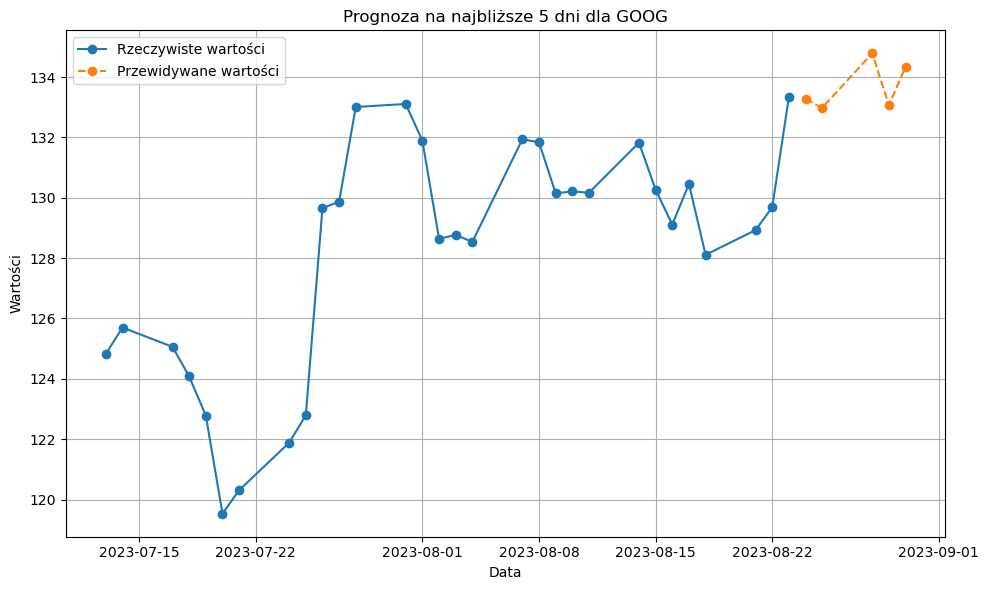

In [7]:
edit_predictions('goog', pipeline_lr, X_test)

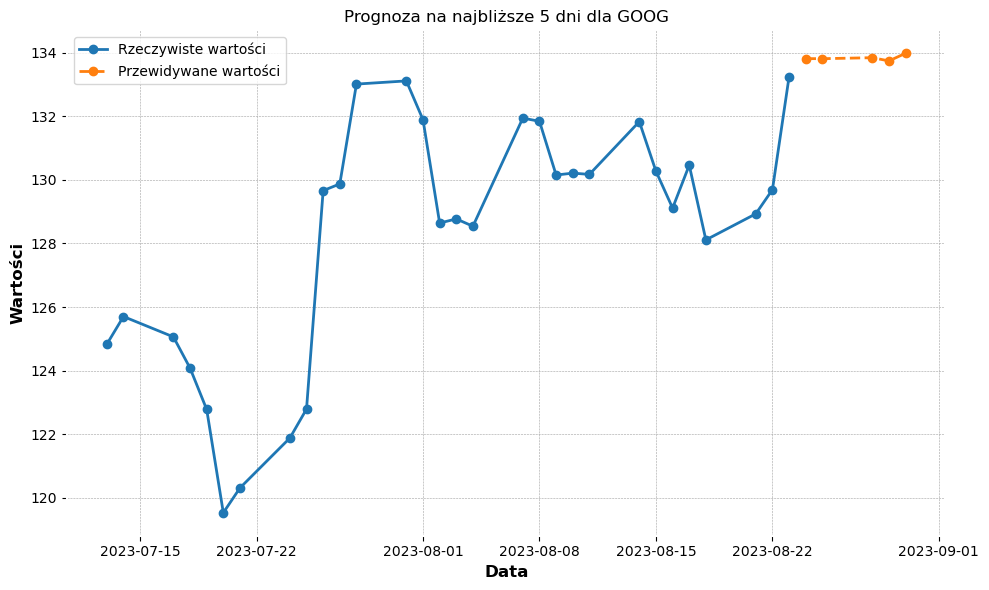

In [79]:
edit_predictions('goog', model_RF)

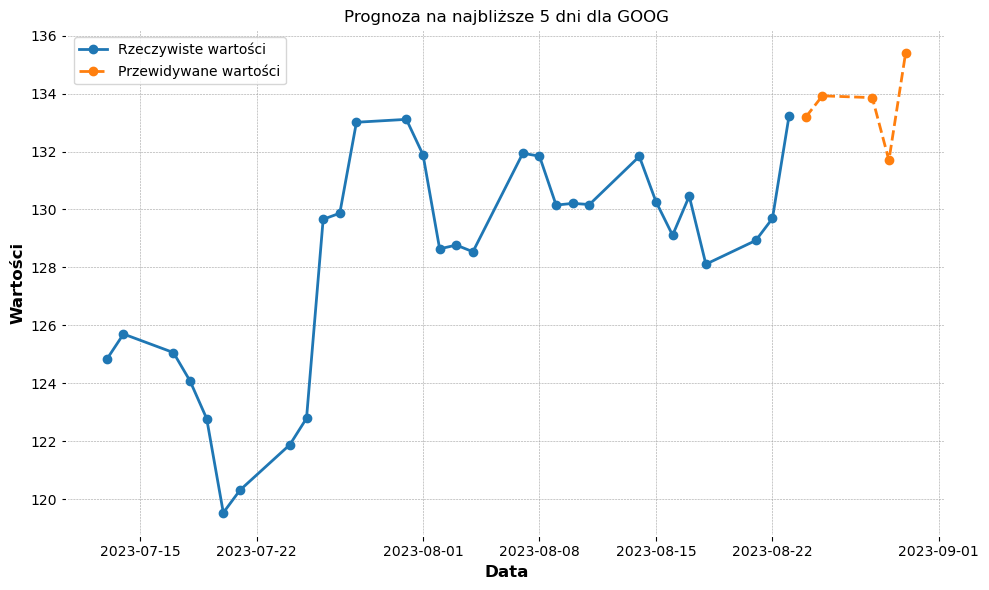

In [80]:
edit_predictions('goog', xgb_model)

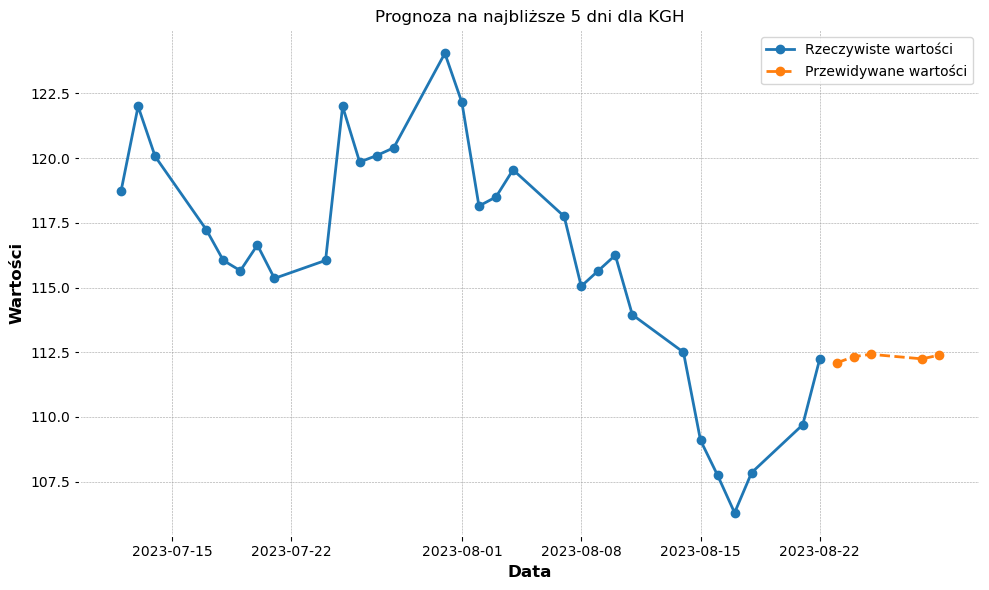

In [78]:
edit_predictions('kgh', pipeline_lr)

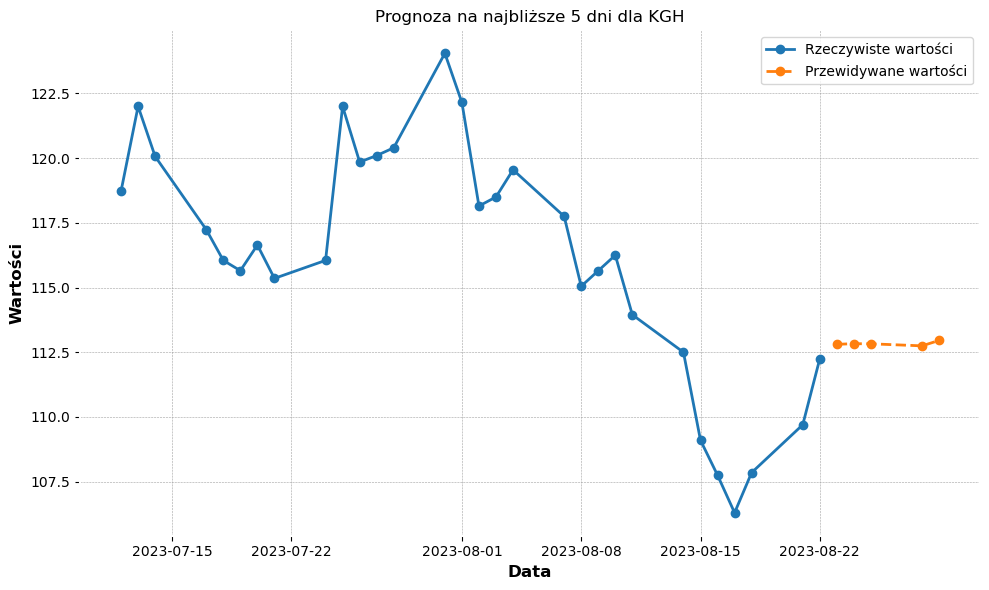

In [83]:
edit_predictions('kgh', model_RF)

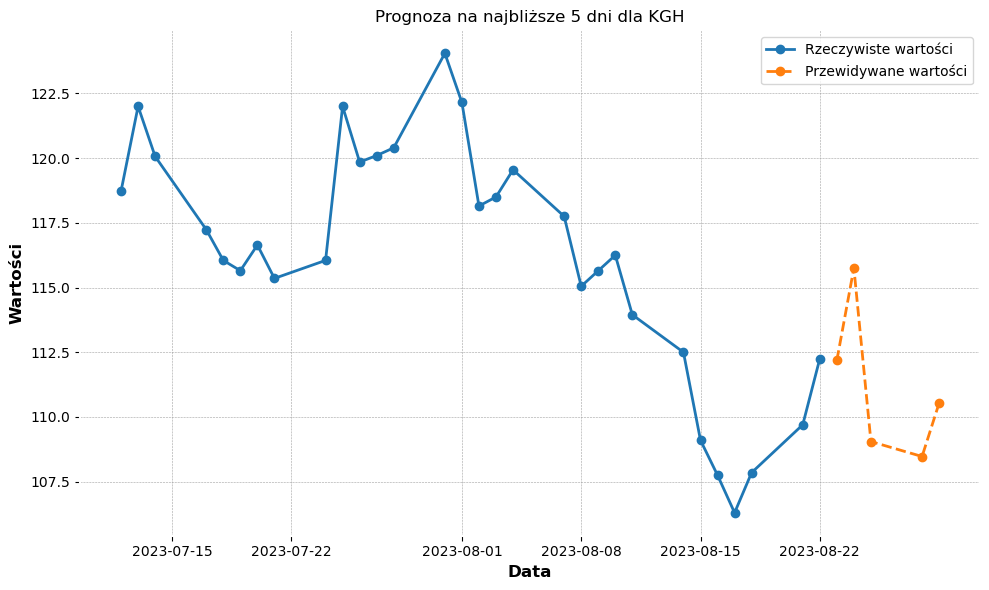

In [82]:
edit_predictions('kgh', xgb_model)

In [8]:
def gradio_generator(company_name: str):
    company_name = company_name
    pred_df = load_data(company_name)
    pred_df['Company'] = company_name.upper()
    pred_df['Close_pred'] = pred_df['Close'].shift(-1)
    pred_df['Close_diff'] = pred_df['Close'] - pred_df['Close'].shift(1)
    pred_df = generate_features(pred_df)
    pred_df = pred_df.iloc[-30:]
    y_pred = pipeline_lr.predict(pred_df.iloc[:,8:])
    
    y_true = pred_df['Close']
    X_test.reset_index(drop=True, inplace=True)
    initial_prices = pred_df['Close'].values[-30:]
    new_prices = np.zeros((len(initial_prices), 5))
    
    for i in range(5):
        new_prices[:, i] = np.cumsum(y_pred[:, i]) + initial_prices
    
    y_pred = new_prices[-1]
    
    start_date = pd.to_datetime(pred_df['Date'].iloc[0])
    dates_pred = pd.date_range(start=start_date, periods=(len(y_true) + len(y_pred)), freq='B')

    y_true = np.concatenate([y_true.values, [np.nan] * len(y_pred)])

    plt.figure(figsize=(10, 6))
    plt.plot(dates_pred, y_true, label='Rzeczywiste wartości', marker='o')
    plt.plot(dates_pred[-len(y_pred):], y_pred, label='Przewidywane wartości', marker='o', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Wartości')
    plt.title(f'Prognoza na najbliższe 5 dni dla {company_name.upper()}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return plt

In [9]:
iface = gr.Interface(
    fn=gradio_generator,
    inputs=gr.inputs.Textbox(label="Nazwa spółki", type="text"),
    outputs="plot",
    live=False
)

In [10]:
iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
